In [8]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

# Exploratory Data Analysis
df_bon_beam

- 4998 unique questions from numina-math: it has the columns (question, method,	N,	beam_width,	max_iteration,	sl (aka, soft label), token_count, time, and sb_idx (aka, question id)).

In [9]:
# df_bon_beam.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_df.csv", index=False)
df_bon_beam = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_df.csv")

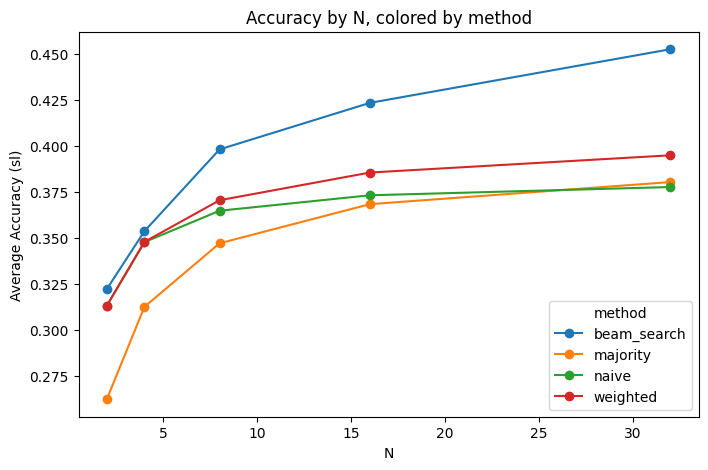

In [4]:
# accuracy over the entire dataset.
import matplotlib.pyplot as plt

avg_acc = df_bon_beam.groupby(["N", "method"])["sl"].mean().reset_index()
plt.figure(figsize=(8,5))
for method, group in avg_acc.groupby("method"):
    group_sorted = group.sort_values("N")
    plt.plot(group_sorted["N"], group_sorted["sl"], marker="o", label=method)
plt.xlabel("N")
plt.ylabel("Average Accuracy (sl)")
plt.title("Accuracy by N, colored by method")
plt.legend(title="method")
plt.show()

/tmp/ipykernel_609000/495161294.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
/tmp/ipykernel_609000/495161294.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")


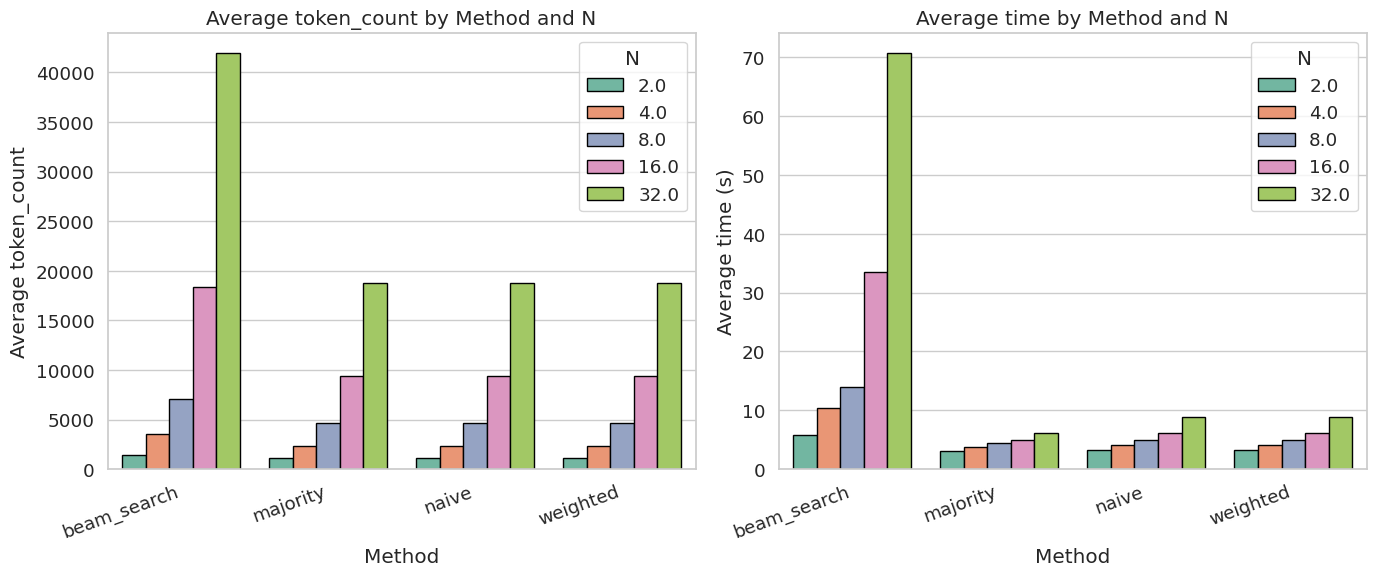

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

palette = sns.color_palette("Set2", n_colors=len(df_bon_beam["N"].unique()))

# token_count plot
df_token = df_bon_beam.groupby(["method", "N"])["token_count"].mean().reset_index()
sns.barplot(
    data=df_token,
    x="method",
    y="token_count",
    hue="N",
    ax=axs[0],
    palette=palette,
    edgecolor="black"
)
axs[0].set_ylabel("Average token_count")
axs[0].set_xlabel("Method")
axs[0].set_title("Average token_count by Method and N")
axs[0].legend(title="N", loc="upper right", frameon=True)

# time plot
df_time = df_bon_beam.groupby(["method", "N"])["time"].mean().reset_index()
sns.barplot(
    data=df_time,
    x="method",
    y="time",
    hue="N",
    ax=axs[1],
    palette=palette,
    edgecolor="black"
)
axs[1].set_ylabel("Average time (s)")
axs[1].set_xlabel("Method")
axs[1].set_title("Average time by Method and N")
axs[1].legend(title="N", loc="upper right", frameon=True)

for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")

plt.tight_layout()
plt.show()

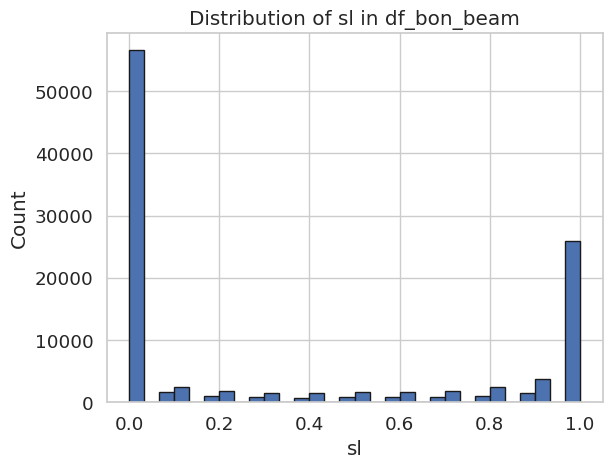

In [6]:
plt.hist(df_bon_beam['sl'], bins=30, edgecolor='k')
plt.xlabel('sl')
plt.ylabel('Count')
plt.title('Distribution of sl in df_bon_beam')
plt.show()

We will route between 22 configurations per question.

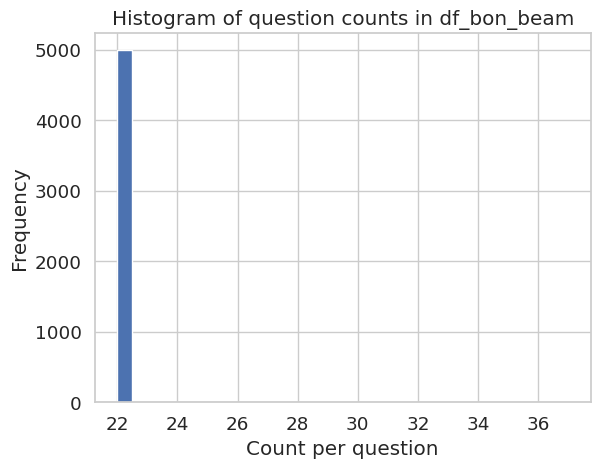

In [7]:
import matplotlib.pyplot as plt

df_bon_beam['question'].value_counts().hist(bins=30)
plt.xlabel("Count per question")
plt.ylabel("Frequency")
plt.title("Histogram of question counts in df_bon_beam")
plt.show()

# Routing

In [102]:
# do a train test split, and keep track of indices.
from sklearn.model_selection import train_test_split

# create train/test split based on 'sb_idx' (query identifier)

unique_sb_idx = df_bon_beam['sb_idx'].unique()

# Split sb_idx into train/test
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.20, # .15
    random_state=9 # 6
)

# Divide queries (represented by sb_idx) into train and test
df_train = df_bon_beam[df_bon_beam['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test = df_bon_beam[df_bon_beam['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [103]:
df_test.shape

(22206, 13)

In [161]:
# df_train.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon_beam_train_df.csv", index=False)
# df_test.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon_beam_test_df.csv", index=False)
df_train = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon_beam_train_df.csv")
df_test = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon_beam_test_df.csv")

df_train.head()
df_test.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx,method_beam_search,method_maj,method_naive,method_weighted
0,"Given that $b$ is a multiple of $2373$, find t...",beam_search,2.0,2.0,40.0,0.0,928,3.41,3679,True,False,False,False
1,"In triangle $ABC$, $CA = CB$, and $D$ is the m...",beam_search,2.0,2.0,40.0,0.0,1441,4.93,5998,True,False,False,False
2,"At its Grand Opening, the Guthrie Market distr...",beam_search,2.0,2.0,40.0,1.0,861,3.37,1426,True,False,False,False
3,"Let \( p = 2^{3009}, q = 3^{2006}, \) and \( r...",beam_search,2.0,2.0,40.0,1.0,1387,5.09,6860,True,False,False,False
4,"Given the function $f(x)=x\ln x$, if $0 \lt x_...",beam_search,2.0,2.0,40.0,0.0,2371,8.12,4236,True,False,False,False


In [162]:
df_test.shape

(22206, 13)

In [163]:
X_train = np.load('/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-test/X.npy')
# X_train = np.load('/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-BERT-test/X.npy')

In [164]:
X_train.shape

(22206, 1544)

In [ ]:
# create features for train + test sets.
# bsub -gpu "num=1/task:mode=exclusive_process:gmodel=NVIDIAA100_SXM4_80GB" 
# -M 200G -J heart-feature -oo /dccstor/gma2/jhjenny9/search-and-learn/data/heart-feature.out 
# -eo /dccstor/gma2/jhjenny9/search-and-learn/data/heart-feature.err 
# python scripts/features/extract_features_simple.py 
# --input_csv /dccstor/gma2/jhjenny9/search-and-learn/data/bon_beam_train_df.csv # replace with bon_beam_test_df.csv for test set feature creation.


# train model and perform inference on test set. return the calibrated probabilities.
# python scripts/training/train_calib.py \
#   --X_train /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-train-morn/X.npy \
#   --y_train /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-train-morn/y.npy \
#   --X_test /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-test-morn/X.npy \
#   --y_test /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-test-morn/y.npy \
#   --output_dir /dccstor/gma2/jhjenny9/search-and-learn/data/beam-bon-model-morn

Load in completed predicted probabilities.

In [165]:
ys = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-model/bon-beam-model/true_labels.npy")
calibrated_probs = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-model/bon-beam-model/calibrated_probs.npy")
# ys = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/BERT-model/BERT-model/true_labels.npy")
# calibrated_probs = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/BERT-model/BERT-model/calibrated_probs.npy")

print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs.shape

(22206,) 2.209193553426303e-05 0.9999314546585083
(22206,) 0.0 1.0


((22206,), (22206,))

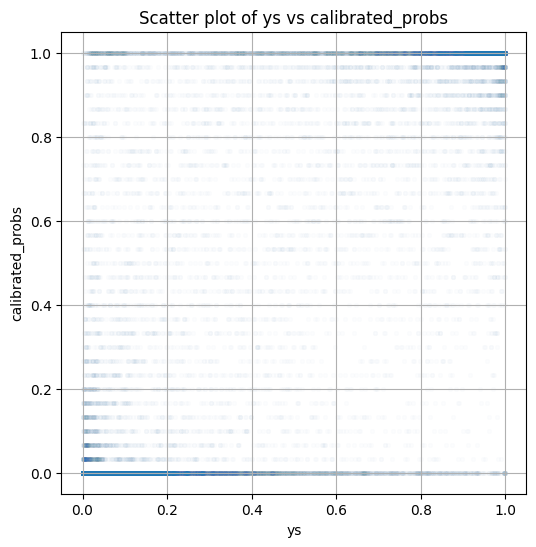

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(calibrated_probs, ys, alpha=0.01, s=8)
plt.xlabel("ys")
plt.ylabel("calibrated_probs")
plt.title("Scatter plot of ys vs calibrated_probs")
plt.grid(True)
plt.show()


In [166]:
df_test['calibrated_probs'] = calibrated_probs

bin
(-0.001, 0.0333]    5402
(0.0333, 0.0667]    2162
(0.0667, 0.1]       1356
(0.1, 0.133]         987
(0.133, 0.167]       700
(0.167, 0.2]         608
(0.2, 0.233]         517
(0.233, 0.267]       475
(0.267, 0.3]         418
(0.3, 0.333]         428
(0.333, 0.367]       402
(0.367, 0.4]         390
(0.4, 0.433]         350
(0.433, 0.467]       347
(0.467, 0.5]         334
(0.5, 0.533]         304
(0.533, 0.567]       302
(0.567, 0.6]         296
(0.6, 0.633]         311
(0.633, 0.667]       336
(0.667, 0.7]         310
(0.7, 0.733]         335
(0.733, 0.767]       323
(0.767, 0.8]         379
(0.8, 0.833]         426
(0.833, 0.867]       445
(0.867, 0.9]         481
(0.9, 0.933]         653
(0.933, 0.967]       803
(0.967, 1.0]        1626
Name: count, dtype: int64


/tmp/ipykernel_1496251/1449942996.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test.groupby("bin").agg(


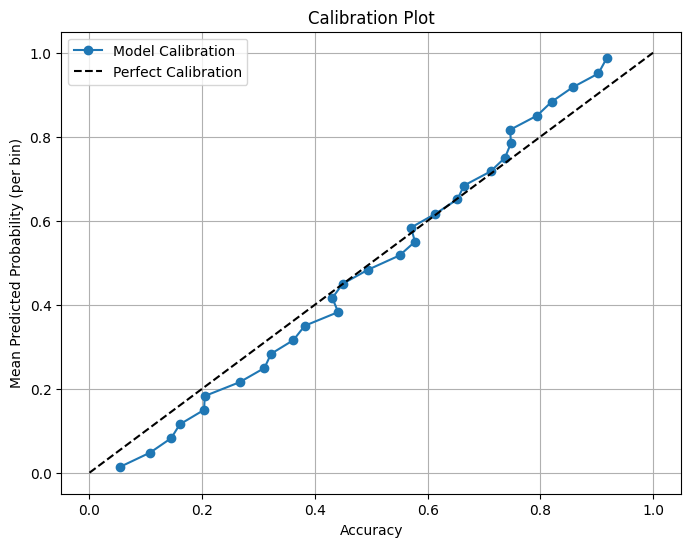

In [167]:
# plot a calibration plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 30
df_test["bin"] = pd.cut(calibrated_probs, bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test.groupby("bin").agg(
    avg_pred_prob=("calibrated_probs", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Print the number of points in each bin
print(calibration["count"])

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.


we obtain a predicted cost by taking an average of points across the training set.

In [168]:
# Create new columns for predicted token count and time based on group means
group_means = df_train.groupby(["method", "N", "beam_width", "max_iteration"])[["token_count", "time"]].mean().reset_index()
group_means = group_means.rename(columns={"token_count": "token_count_pred", "time": "time_pred"})

# Merge these means back into df_test
df_test = df_test.merge(group_means, on=["method", "N", "beam_width", "max_iteration"], how="left")

In [169]:
df_test.head()

,question,method,N,beam_width,max_iteration,sl,token_count,time,sb_idx,method_beam_search,method_maj,method_naive,method_weighted,calibrated_probs,bin,token_count_pred,time_pred
0,"Given that $b$ is a multiple of $2373$, find t...",beam_search,2.0,2.0,40.0,0.0,928,3.41,3679,True,False,False,False,0.712480,"(0.7, 0.733]",1484.315171,5.847008
1,"In triangle $ABC$, $CA = CB$, and $D$ is the m...",beam_search,2.0,2.0,40.0,0.0,1441,4.93,5998,True,False,False,False,0.929762,"(0.9, 0.933]",1484.315171,5.847008
2,"At its Grand Opening, the Guthrie Market distr...",beam_search,2.0,2.0,40.0,1.0,861,3.37,1426,True,False,False,False,0.346296,"(0.333, 0.367]",1484.315171,5.847008
3,"Let \( p = 2^{3009}, q = 3^{2006}, \) and \( r...",beam_search,2.0,2.0,40.0,1.0,1387,5.09,6860,True,False,False,False,0.020976,"(-0.001, 0.0333]",1484.315171,5.847008
4,"Given the function $f(x)=x\ln x$, if $0 \lt x_...",beam_search,2.0,2.0,40.0,0.0,2371,8.12,4236,True,False,False,False,0.108261,"(0.1, 0.133]",1484.315171,5.847008


In [170]:
group_means.head(20)

,method,N,beam_width,max_iteration,token_count_pred,time_pred
0,beam_search,2.0,2.0,40.0,1484.315171,5.847008
1,beam_search,4.0,2.0,40.0,3565.782804,10.506026
2,beam_search,4.0,4.0,40.0,3583.333333,10.800000
3,beam_search,8.0,4.0,20.0,7118.774306,13.948145
4,beam_search,16.0,2.0,40.0,21465.719820,42.911500
5,beam_search,16.0,4.0,20.0,15331.905774,24.462464
6,beam_search,32.0,2.0,20.0,34825.430892,49.405381
7,beam_search,32.0,4.0,40.0,49158.522869,92.089523
8,majority,2.0,0.0,0.0,1164.029611,3.205739
9,majority,4.0,0.0,0.0,2340.723965,3.826848


In [171]:
# get the average accuracy and token_count for each configuration.
config_summary_df = df_test.groupby(["N", "beam_width", "max_iteration", "method"])[
    ["token_count", "time", "sl", "calibrated_probs", "token_count_pred", "time_pred"]
].mean().reset_index()

In [172]:
config_summary_df.head()

,N,beam_width,max_iteration,method,token_count,time,sl,calibrated_probs,token_count_pred,time_pred
0,2.0,0.0,0.0,majority,1161.653202,3.118414,0.261117,0.283097,1164.029611,3.205739
1,2.0,0.0,0.0,naive,1161.653202,3.237714,0.311494,0.304863,1164.029611,3.327415
2,2.0,0.0,0.0,weighted,1161.653202,3.237714,0.311494,0.314541,1164.029611,3.327415
3,2.0,2.0,40.0,beam_search,1473.004012,5.827904,0.328987,0.341117,1484.315171,5.847008
4,4.0,0.0,0.0,majority,2307.248276,3.745695,0.310739,0.289726,2340.723965,3.826848


In [173]:
# remove incomplete configurations (there is not enough data using these configs, to compare to other configurations fairly).
config_summary_df = config_summary_df[~(
    ((config_summary_df['N'] == 4) & (config_summary_df['beam_width'] == 4) & (config_summary_df['max_iteration'] == 40)) |
    ((config_summary_df['N'] == 8) & (config_summary_df['beam_width'] == 4) & (config_summary_df['max_iteration'] == 40))
)]

Route for a given lambda.

In [174]:
def compute_max_utility_pred(df, lambda_, method="oracle", cost="token_count"):
    def get_max_utility(group):
        group = group.copy()
        if method == "oracle":
            group["utility"] = group["sl"] - lambda_ * group[cost]
        elif method == "adaptive_router":
            group["utility"] = group["calibrated_probs"] - lambda_ * group[cost]
        else:
            raise ValueError(f"Invalid method: {method}")
        idx_max = group["utility"].idxmax()

        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "calibrated_probs"],
            "max_sl": group.loc[idx_max, "sl"],
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "beam_width": group.loc[idx_max, "beam_width"],
            "max_iteration": group.loc[idx_max, "max_iteration"]
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

Route for a list of lambdas.

In [175]:
def get_router_df(input_df, lambda_list, method="oracle", cost="token_count"):
    results = []

    for lambda_value in lambda_list:
        adaptive_router = compute_max_utility_pred(input_df, lambda_value, method, cost)
        average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
        average_cost = adaptive_router["max_cost"].mean() # average over all questions in test set for adaptive router.
        average_time = adaptive_router["max_time"].mean()
        average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
        
        results.append({
            "lambda": lambda_value,
            "sl": average_accuracy,
            "predicted_prob": average_predicted_prob,
            "token_count": average_cost,
            "time": average_time,
        })

    # Convert to DataFrame
    output_df = pd.DataFrame(results)
    output_df["method"] = method

    return output_df

In [176]:
oracle_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=50), method="oracle", cost="token_count")
adaptive_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=50), method="adaptive_router", cost="token_count_pred")
adaptive_oracle_tc = get_router_df(df_test, lambda_list=np.logspace(-7, -1, num=50), method="adaptive_router", cost="token_count")

adaptive_oracle_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", cost="time")
adaptive_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="adaptive_router", cost="time_pred")
oracle_lat = get_router_df(df_test, lambda_list=np.logspace(-5, -1, num=50), method="oracle", cost="time")

/tmp/ipykernel_1496251/2640198696.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1496251/2640198696.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_1496251/2640198696.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

In [177]:
adaptive_tc.head()

,lambda,sl,predicted_prob,token_count,time,method
0,1.000000e-07,0.494219,0.514166,29585.962126,42.936545,adaptive_router
1,1.325711e-07,0.492647,0.514095,29019.549502,42.013628,adaptive_router
2,1.757511e-07,0.493068,0.513986,28236.729568,40.587681,adaptive_router
3,2.329952e-07,0.492137,0.513843,27565.075748,39.498173,adaptive_router
4,3.088844e-07,0.492204,0.513610,26695.702990,38.081209,adaptive_router


In [178]:
adaptive_lat.head()

,lambda,sl,predicted_prob,token_count,time,method
0,0.000010,0.496390,0.514256,30792.860465,44.640033,adaptive_router
1,0.000012,0.496390,0.514255,30788.909635,44.630372,adaptive_router
2,0.000015,0.496390,0.514254,30751.025249,44.576804,adaptive_router
3,0.000018,0.496368,0.514250,30715.958140,44.477701,adaptive_router
4,0.000021,0.496368,0.514246,30645.998007,44.318837,adaptive_router


In [179]:
oracle_tc.head()

,lambda,sl,predicted_prob,token_count,time,method
0,1.000000e-07,0.578782,0.394399,5799.483056,9.379017,oracle
1,1.325711e-07,0.578782,0.394399,5799.483056,9.379017,oracle
2,1.757511e-07,0.578782,0.394399,5799.483056,9.379017,oracle
3,2.329952e-07,0.578782,0.394399,5799.483056,9.379017,oracle
4,3.088844e-07,0.578782,0.394399,5799.483056,9.379017,oracle


In [180]:
oracle_lat.head()

,lambda,sl,predicted_prob,token_count,time,method
0,0.000010,0.578782,0.397457,6153.938206,9.215289,oracle
1,0.000012,0.578782,0.397457,6153.938206,9.215289,oracle
2,0.000015,0.578782,0.397457,6153.938206,9.215289,oracle
3,0.000018,0.578782,0.397457,6153.938206,9.215289,oracle
4,0.000021,0.578782,0.397457,6153.938206,9.215289,oracle


Fill in "-1"'s for the configuration-related columns for the router + oracle.

In [181]:
adaptive_oracle_tc['N'] = -1
adaptive_oracle_tc['beam_width'] = -1
adaptive_oracle_tc['max_iteration'] = -1

adaptive_oracle_lat['N'] = -1
adaptive_oracle_lat['beam_width'] = -1
adaptive_oracle_lat['max_iteration'] = -1

adaptive_tc['N'] = -1
adaptive_tc['beam_width'] = -1
adaptive_tc['max_iteration'] = -1

adaptive_lat['N'] = -1
adaptive_lat['beam_width'] = -1
adaptive_lat['max_iteration'] = -1

oracle_tc['N'] = -1
oracle_tc['beam_width'] = -1
oracle_tc['max_iteration'] = -1

oracle_lat['N'] = -1
oracle_lat['beam_width'] = -1
oracle_lat['max_iteration'] = -1

In [182]:
config_summary_df.rename(columns={"calibrated_probs": "predicted_prob"}, inplace=True)

In [183]:
config_summary_df = config_summary_df.drop(columns=["token_count_pred", "time_pred"]) # these columns are only used for adaptive routing.
config_summary_df.head()

,N,beam_width,max_iteration,method,token_count,time,sl,predicted_prob
0,2.0,0.0,0.0,majority,1161.653202,3.118414,0.261117,0.283097
1,2.0,0.0,0.0,naive,1161.653202,3.237714,0.311494,0.304863
2,2.0,0.0,0.0,weighted,1161.653202,3.237714,0.311494,0.314541
3,2.0,2.0,40.0,beam_search,1473.004012,5.827904,0.328987,0.341117
4,4.0,0.0,0.0,majority,2307.248276,3.745695,0.310739,0.289726


In [184]:
adaptive_oracle_tc['method'] = 'oracle_cost'
adaptive_oracle_lat['method'] = 'oracle_cost'

In [185]:
# outer join on the shared columns
df_1_tc = pd.merge(
    adaptive_tc,
    config_summary_df,
    on=["sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
df_2_tc = pd.merge(
    df_1_tc,
    oracle_tc,
    on=["lambda", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
df_3_tc = pd.merge(
    df_2_tc,
    adaptive_oracle_tc,
    on=["lambda", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
# Replace NaN values with -1 for plotting purposes
query_optimal_tc = df_3_tc.fillna(-1)

In [186]:
# outer join on the shared columns
df_1_late = pd.merge(
    adaptive_lat,
    config_summary_df,
    on=["sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration", "method"],
    how="outer"
)
df_2_late = pd.merge(
    df_1_late,
    oracle_lat,
    on=["lambda", "method", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration"],
    how="outer"
)
df_3_late = pd.merge(
    df_2_late,
    adaptive_oracle_lat,
    on=["lambda", "method", "sl", "token_count", "time", "predicted_prob", "N", "beam_width", "max_iteration"],
    how="outer"
)

# Replace NaN values with -1 for plotting purposes
query_optimal_late = df_3_late.fillna(-1)

In [187]:
query_optimal_tc['method'].unique() 

array(['adaptive_router', 'oracle_cost', 'oracle', 'majority', 'naive',
       'weighted', 'beam_search'], dtype=object)

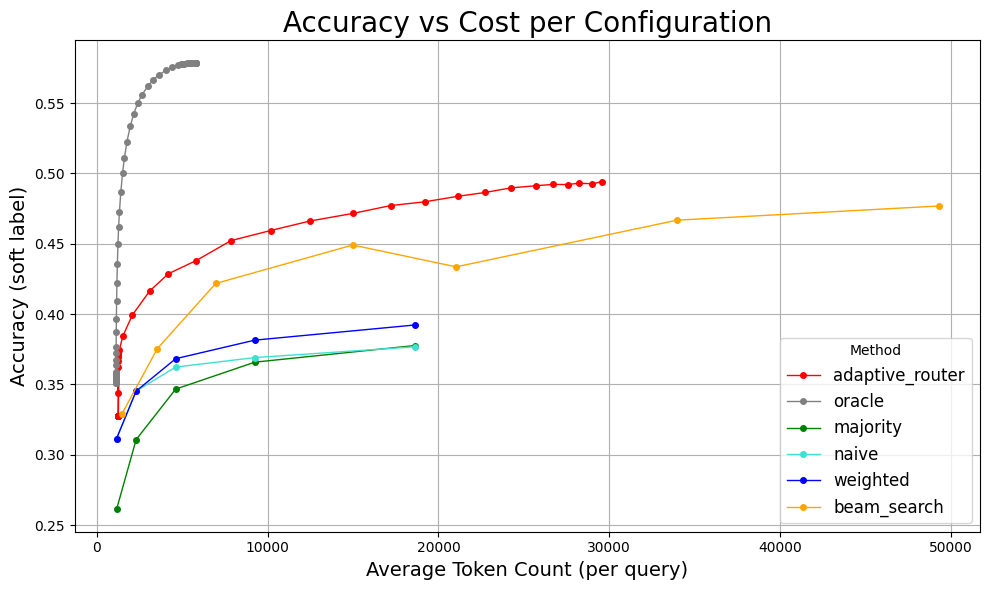

In [188]:
# router on token count.
method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "adaptive_oracle": "brown",  # Query-adaptive router with oracle cost
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_tc["method"].unique():
    if method != "oracle_cost":
        method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
        color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
        plt.plot(
            method_df["token_count"], 
            method_df["sl"], 
            marker="o", 
            linestyle="-", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )

# Add labels and title
plt.xlabel("Average Token Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

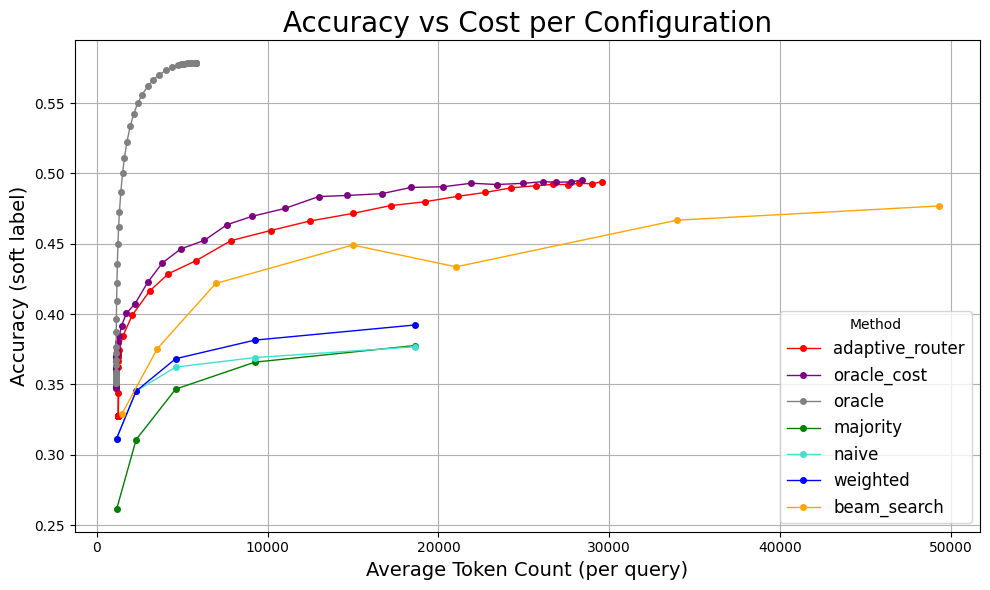

In [131]:
# router on token count.
method_colors = {
    "oracle_cost": "purple",  # Query-adaptive router with oracle cost
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "adaptive_oracle": "brown",  # Query-adaptive router with oracle cost
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_tc["method"].unique():
    method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Token Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

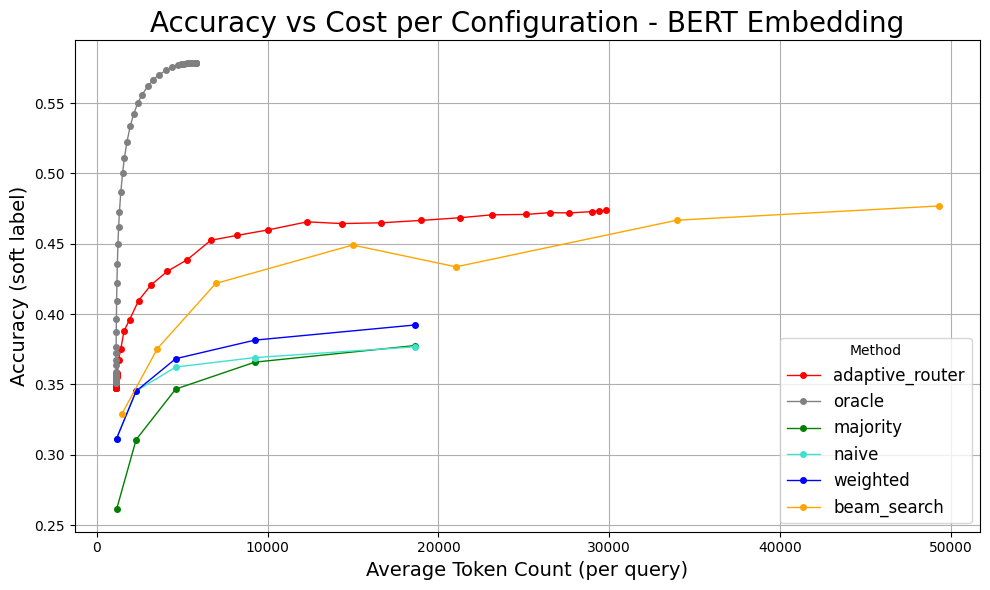

In [78]:
# router on token count.
method_colors = {
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_tc["method"].unique():
    method_df = query_optimal_tc[query_optimal_tc["method"] == method].sort_values("token_count")
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Token Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration - BERT Embedding", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

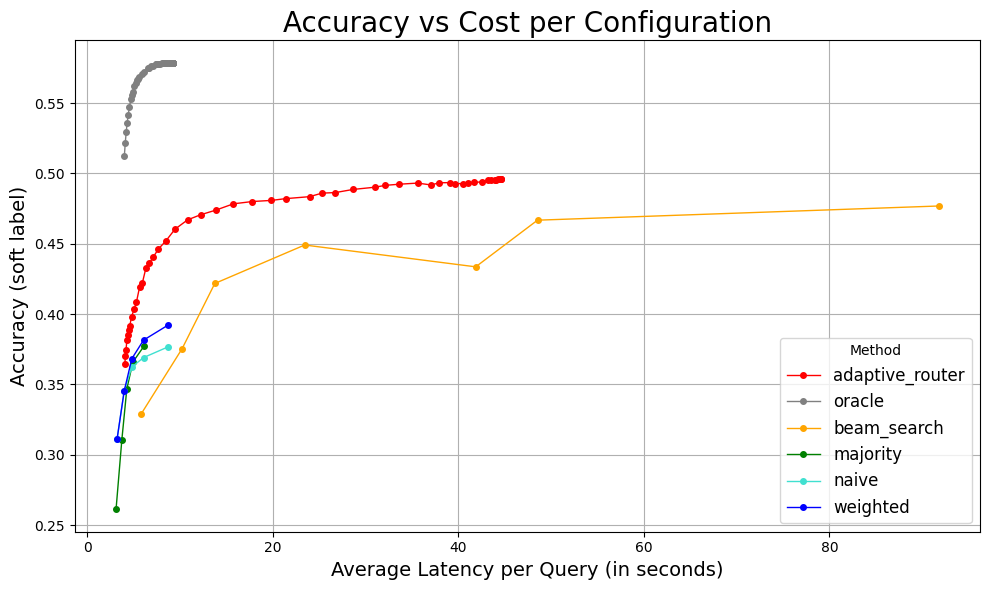

In [189]:
# Router on latency.
method_colors = {
    "oracle_cost": "purple",
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_late["method"].unique():
    if method != "oracle_cost":
        method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
        color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
        plt.plot(
            method_df["time"], 
            method_df["sl"], 
            marker="o", 
            linestyle="-", 
            color=color, 
            label=method,
            markersize=4,
            linewidth=1
        )

# Add labels and title
plt.xlabel("Average Latency per Query (in seconds)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

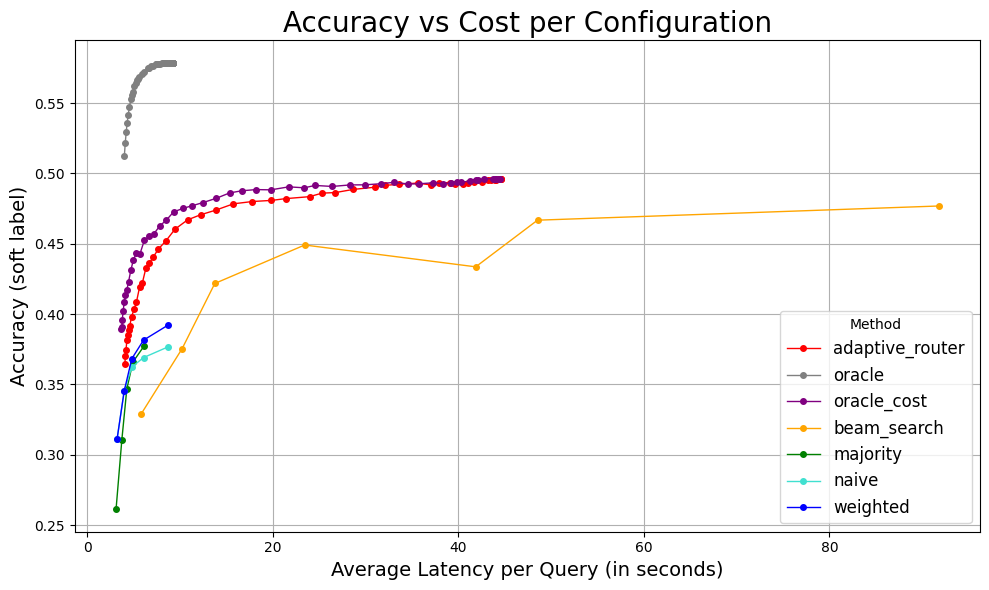

In [130]:
# Router on latency.
method_colors = {
    "oracle_cost": "purple",
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_late["method"].unique():
    method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["time"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Latency per Query (in seconds)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

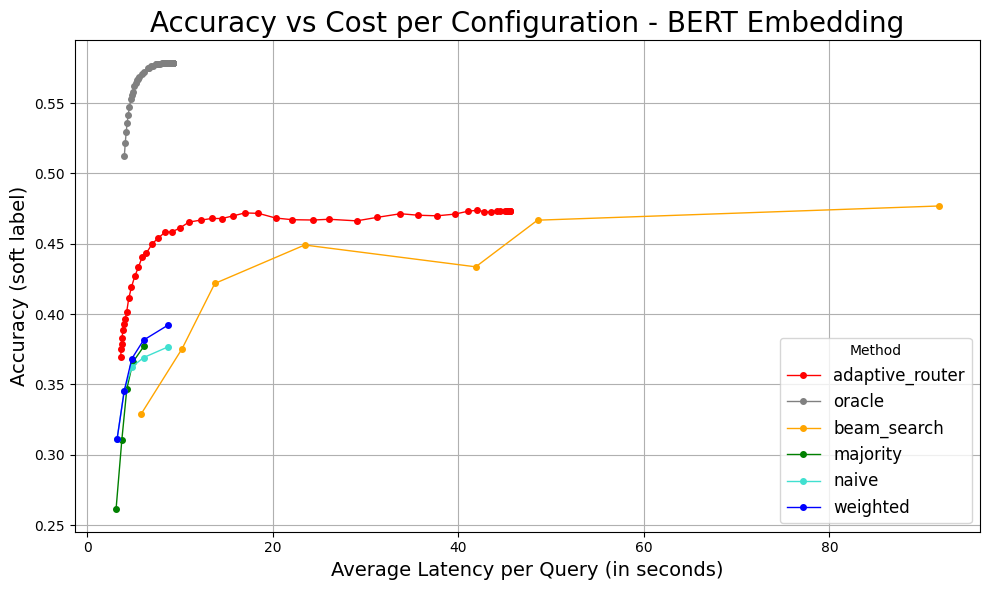

In [80]:
# Router on latency.
method_colors = {
    "adaptive_router": "red",  # Query-adaptive router
    "oracle": "gray",  # Oracle router
    "beam_search": "orange",
    "majority": "green",
    "weighted": "blue",
    "naive": "turquoise"
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_late["method"].unique():
    method_df = query_optimal_late[query_optimal_late["method"] == method].sort_values("time")
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["time"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("Average Latency per Query (in seconds)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration - BERT Embedding", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

Plot accuracies on the test set (the dataset that routing was performed on).

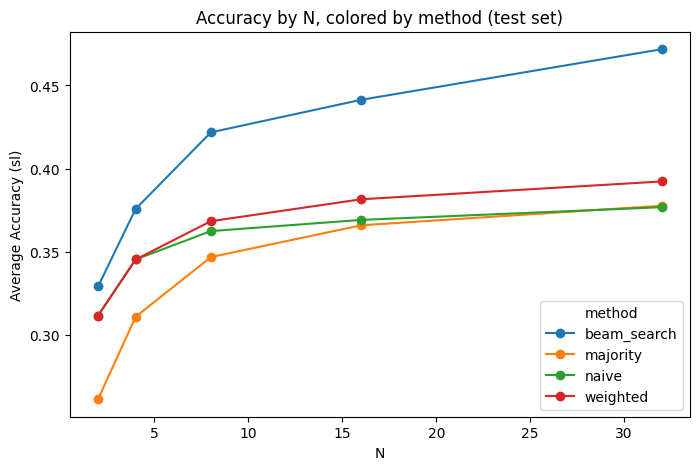

In [49]:
import matplotlib.pyplot as plt

avg_acc = df_test.groupby(["N", "method"])["sl"].mean().reset_index()
plt.figure(figsize=(8,5))
for method, group in avg_acc.groupby("method"):
    group_sorted = group.sort_values("N")
    plt.plot(group_sorted["N"], group_sorted["sl"], marker="o", label=method)
plt.xlabel("N")
plt.ylabel("Average Accuracy (sl)")
plt.title("Accuracy by N, colored by method (test set)")
plt.legend(title="method")
plt.show()